In [1]:
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model
from keras.optimizers import SGD, RMSprop, Adam, Nadam
from keras.applications.vgg16 import preprocess_input
from keras.callbacks import ModelCheckpoint
from keras.models import model_from_json
from keras.callbacks import TensorBoard
from keras import backend as K

import numpy as np

Using TensorFlow backend.


# TODO
- more aggresive data augmentation
- more aggressive dropout
- use of L1 and L2 regularization (also known as "weight decay")
- fine-tuning one more convolutional block (alongside greater regularization)


In [2]:
# dimensions of our images.
img_width, img_height = 224, 224

train_data_dir = 'data/train'
validation_data_dir = 'data/valid'
test_data_dir = 'data/test'
nb_train_samples = 6363
nb_epochs = 15
batch_size = 16
nb_classes = 3

In [3]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [4]:
train_datagen = ImageDataGenerator(rescale=1. / 255)
itr = train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=1000,
    class_mode='categorical')

Found 6363 images belonging to 3 classes.


In [5]:
X, y = itr.next()

In [6]:
print(X.shape)
print(y.shape)

(1000, 224, 224, 3)
(1000, 3)


In [ ]:
pre_processed_X_incep = preprocess_input(X)

In [40]:
base_model = applications.VGG16(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))
print('Model loaded.')

Model loaded.


In [41]:
x = base_model.output
x = Flatten()(x)
predictions = Dense(nb_classes, activation='softmax', kernel_initializer='glorot_uniform')(x)

In [42]:
# this is the model we will train
# add your top layer block to your base model
model = Model(base_model.input, predictions)

In [11]:
def printAllLayers():
    for i, layer in enumerate(model.layers):
       print(i, layer.name)

In [43]:
# let's visualize layer names and layer indices to see how many layers
# we should freeze:
printAllLayers()

0 input_2
1 block1_conv1
2 block1_conv2
3 block1_pool
4 block2_conv1
5 block2_conv2
6 block2_pool
7 block3_conv1
8 block3_conv2
9 block3_conv3
10 block3_pool
11 block4_conv1
12 block4_conv2
13 block4_conv3
14 block4_pool
15 block5_conv1
16 block5_conv2
17 block5_conv3
18 block5_pool
19 flatten_2
20 dense_3


In [44]:
# set the first 25 layers (up to the last conv block)
# to non-trainable (weights will not be updated)
for layer in model.layers[:19]:
    layer.trainable = False

In [45]:
def printTrainableLayers():
    for i, layer in enumerate(model.layers):
       if layer.trainable == True: 
           print(i, layer.name)

In [46]:
# let's visualize layer names and layer indices to see how many layers
# we should freeze:
printTrainableLayers()

19 flatten_2
20 dense_3


In [47]:
# checkpoint
filepath="vgg16-top-weights-improvement-{epoch:02d}-{val_loss:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

In [48]:
#histogram_freq=0, write_graph=True, write_grads=False, write_images=False, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None)
tbCallBack = TensorBoard(log_dir='./Graph', histogram_freq=0, write_graph=True, write_images=True)
callbacks_list.append(tbCallBack)

In [49]:
#opt = RMSprop(lr=0.1)
opt = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08 )# decay=0.0
#SGD(lr=1e-4, momentum=0.9)
#opt=SGD(lr=0.01, momentum=0.9, nesterov=True, decay=0.5)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Goal: < 0.96188 val_loss

In [50]:
history = model.fit(pre_processed_X, y, batch_size=16, epochs=8, callbacks=callbacks_list, validation_split=0.3, shuffle=True, initial_epoch=0)

Train on 4454 samples, validate on 1909 samples
Epoch 1/8
4454/4454 [==============================] - 87s - loss: 1.2953 - acc: 0.3803 - val_loss: 1.1292 - val_acc: 0.3887
Epoch 2/8
4454/4454 [==============================] - 87s - loss: 1.1800 - acc: 0.3992 - val_loss: 1.0873 - val_acc: 0.4144
Epoch 3/8
4454/4454 [==============================] - 86s - loss: 1.1684 - acc: 0.4012 - val_loss: 1.0495 - val_acc: 0.4274
Epoch 4/8
4454/4454 [==============================] - 86s - loss: 1.2063 - acc: 0.3934 - val_loss: 1.1131 - val_acc: 0.3394
Epoch 5/8
4454/4454 [==============================] - 86s - loss: 1.1867 - acc: 0.3994 - val_loss: 1.0690 - val_acc: 0.3897
Epoch 6/8
4454/4454 [==============================] - 86s - loss: 1.2088 - acc: 0.4035 - val_loss: 1.3394 - val_acc: 0.4274
Epoch 7/8
4454/4454 [==============================] - 82s - loss: 1.2068 - acc: 0.4084 - val_loss: 1.0796 - val_acc: 0.3897
Epoch 8/8
4454/4454 [==============================] - 80s - loss: 1.1704 - a

In [51]:
# serialize model to JSON
model_json = model.to_json()
with open("vgg16_top_only.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("vgg16_top_only.h5")
print("Saved model to disk")

Saved model to disk


In [61]:
# load json and create model
json_file = open("vgg16_top_only.json", 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)

In [62]:
opt = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08 )# decay=0.0
#SGD(lr=1e-4, momentum=0.9)
#opt=SGD(lr=0.01, momentum=0.9, nesterov=True, decay=0.5)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [63]:
model.load_weights("vgg16-top-weights-improvement-02-1.05.hdf5")

In [64]:
history2 = model.fit(pre_processed_X, y, batch_size=16, epochs=16, callbacks=callbacks_list, validation_split=0.3, shuffle=True, initial_epoch=10)

Train on 4454 samples, validate on 1909 samples
Epoch 11/16
4454/4454 [==============================] - 210s - loss: 1.0539 - acc: 0.4448 - val_loss: 1.0356 - val_acc: 0.4741
Epoch 12/16
4454/4454 [==============================] - 169s - loss: 1.0603 - acc: 0.4374 - val_loss: 1.0759 - val_acc: 0.4804
Epoch 13/16
4454/4454 [==============================] - 77s - loss: 1.0484 - acc: 0.4421 - val_loss: 1.0539 - val_acc: 0.4034
Epoch 14/16
4454/4454 [==============================] - 77s - loss: 1.0422 - acc: 0.4511 - val_loss: 1.1380 - val_acc: 0.4034
Epoch 15/16
4454/4454 [==============================] - 77s - loss: 1.0511 - acc: 0.4466 - val_loss: 1.0617 - val_acc: 0.4248
Epoch 16/16
4454/4454 [==============================] - 77s - loss: 1.0526 - acc: 0.4443 - val_loss: 1.0359 - val_acc: 0.4694


In [65]:
# serialize model to JSON
model_json = model.to_json()
with open("vgg16_top_only_2.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("vgg16_top_only_2.h5")
print("Saved model to disk")

Saved model to disk


In [78]:
# load json and create model
json_file = open("vgg16_top_only_2.json", 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)

In [79]:
opt = Adam(lr=0.00001, beta_1=0.9, beta_2=0.999, epsilon=1e-08 )# decay=0.0
#SGD(lr=1e-4, momentum=0.9)
#opt=SGD(lr=0.01, momentum=0.9, nesterov=True, decay=0.5)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [80]:
model.load_weights("vgg16-top-weights-improvement-10-1.04.hdf5")

In [81]:
history3 = model.fit(pre_processed_X, y, batch_size=16, epochs=22, callbacks=callbacks_list, validation_split=0.3, shuffle=True, initial_epoch=16)

Train on 4454 samples, validate on 1909 samples
Epoch 17/22
4454/4454 [==============================] - 89s - loss: 1.0343 - acc: 0.4728 - val_loss: 1.0353 - val_acc: 0.4772
Epoch 18/22
4454/4454 [==============================] - 79s - loss: 1.0360 - acc: 0.4690 - val_loss: 1.0358 - val_acc: 0.4709
Epoch 19/22
4454/4454 [==============================] - 78s - loss: 1.0342 - acc: 0.4697 - val_loss: 1.0421 - val_acc: 0.4269
Epoch 20/22
4454/4454 [==============================] - 79s - loss: 1.0358 - acc: 0.4719 - val_loss: 1.0378 - val_acc: 0.4662
Epoch 21/22
4454/4454 [==============================] - 78s - loss: 1.0348 - acc: 0.4648 - val_loss: 1.0437 - val_acc: 0.4515
Epoch 22/22
4454/4454 [==============================] - 79s - loss: 1.0348 - acc: 0.4690 - val_loss: 1.0379 - val_acc: 0.4646


In [82]:
# serialize model to JSON
model_json = model.to_json()
with open("vgg16_top_only_3.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("vgg16_top_only_3.h5")
print("Saved model to disk")

Saved model to disk


In [138]:
# load json and create model
json_file = open("vgg16_top_only_3.json", 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)

In [139]:
opt = Adam(lr=1e-6, beta_1=0.9, beta_2=0.999, epsilon=1e-08 )# decay=0.0
#SGD(lr=1e-4, momentum=0.9)
#opt=SGD(lr=0.01, momentum=0.9, nesterov=True, decay=0.5)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [140]:
model.load_weights("vgg16_top_only_3.h5")

In [141]:
history4 = model.fit(pre_processed_X, y, batch_size=16, epochs=30, callbacks=callbacks_list, validation_split=0.3, shuffle=True, initial_epoch=22)

Train on 4454 samples, validate on 1909 samples
Epoch 23/30
4454/4454 [==============================] - 86s - loss: 1.0323 - acc: 0.4742 - val_loss: 1.0357 - val_acc: 0.4683
Epoch 24/30
4454/4454 [==============================] - 91s - loss: 1.0320 - acc: 0.4733 - val_loss: 1.0352 - val_acc: 0.4725
Epoch 25/30
4454/4454 [==============================] - 82s - loss: 1.0321 - acc: 0.4762 - val_loss: 1.0353 - val_acc: 0.4709
Epoch 26/30
4454/4454 [==============================] - 85s - loss: 1.0321 - acc: 0.4744 - val_loss: 1.0359 - val_acc: 0.4662
Epoch 27/30
4454/4454 [==============================] - 102s - loss: 1.0322 - acc: 0.4762 - val_loss: 1.0354 - val_acc: 0.4688
Epoch 28/30
4454/4454 [==============================] - 103s - loss: 1.0320 - acc: 0.4755 - val_loss: 1.0354 - val_acc: 0.4694
Epoch 29/30
4454/4454 [==============================] - 81s - loss: 1.0320 - acc: 0.4764 - val_loss: 1.0356 - val_acc: 0.4704
Epoch 30/30
4454/4454 [==============================] - 209s

In [165]:
predictions = model.predict(pre_processed_X, batch_size=32, verbose=0)

In [166]:
y_actu = y
print(y_actu.shape)

(6363, 3)


In [167]:
y_pred = predictions
print(y_pred.shape)

(6363, 3)


In [168]:
our_labels = (y_pred == y_pred.max(axis=1)[:,None]).astype(int)

In [169]:
from sklearn.metrics import confusion_matrix
# y = (6363, 3)
print(confusion_matrix(y_actu.flatten(), our_labels.flatten())) #confusion_matrix(y_actu, y_pred)

[[9383 3343]
 [3343 3020]]


# Now lets train inceptionv3

In [6]:
from keras.applications.inception_v3 import InceptionV3
from keras.layers import Dense, GlobalAveragePooling2D

In [179]:
# create the base pre-trained model
base_inception_model = InceptionV3(weights='imagenet', include_top=False)

In [180]:
# add a global spatial average pooling layer
x_incep = base_inception_model.output
x_incep = GlobalAveragePooling2D()(x_incep)
# let's add a fully-connected layer
x_incep = Dense(1024, activation='relu', kernel_initializer='glorot_uniform')(x_incep)
# and a logistic layer -- let's say we have 200 classes
predictions_incep = Dense(3, activation='softmax', kernel_initializer='glorot_uniform')(x_incep)

In [181]:
# this is the model we will train
model_inception = Model(inputs=base_inception_model.input, outputs=predictions_incep)

In [182]:
for i, layer in enumerate(model_inception.layers):
       print(i, layer.name)

0 input_4
1 conv2d_95
2 batch_normalization_95
3 activation_95
4 conv2d_96
5 batch_normalization_96
6 activation_96
7 conv2d_97
8 batch_normalization_97
9 activation_97
10 max_pooling2d_5
11 conv2d_98
12 batch_normalization_98
13 activation_98
14 conv2d_99
15 batch_normalization_99
16 activation_99
17 max_pooling2d_6
18 conv2d_103
19 batch_normalization_103
20 activation_103
21 conv2d_101
22 conv2d_104
23 batch_normalization_101
24 batch_normalization_104
25 activation_101
26 activation_104
27 average_pooling2d_10
28 conv2d_100
29 conv2d_102
30 conv2d_105
31 conv2d_106
32 batch_normalization_100
33 batch_normalization_102
34 batch_normalization_105
35 batch_normalization_106
36 activation_100
37 activation_102
38 activation_105
39 activation_106
40 mixed0
41 conv2d_110
42 batch_normalization_110
43 activation_110
44 conv2d_108
45 conv2d_111
46 batch_normalization_108
47 batch_normalization_111
48 activation_108
49 activation_111
50 average_pooling2d_11
51 conv2d_107
52 conv2d_109
53 co

In [184]:
for layer in model_inception.layers[:311]:
    layer.trainable = False

In [185]:
for i, layer in enumerate(model_inception.layers):
       if layer.trainable == True: 
           print(i, layer.name)

311 global_average_pooling2d_3
312 dense_8
313 dense_9


In [204]:
opt = RMSprop(lr=1e-5, rho=0.9)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [197]:
filepath="inception-top-weights-improvement-{epoch:02d}-{val_loss:}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list_inception = [checkpoint]
tbCallBack = TensorBoard(log_dir='./graph_incep_top', histogram_freq=0, write_graph=True, write_images=True)
callbacks_list_inception.append(tbCallBack)

In [205]:
history_incep = model.fit(pre_processed_X_incep, y, batch_size=16, epochs=3, callbacks=callbacks_list_inception, validation_split=0.22, shuffle=True, initial_epoch=2)

ValueError: Input arrays should have the same number of samples as target arrays. Found 6363 input samples and 19089 target samples.

# Gridsearch with scikit-learn

In [7]:
base_inception_model = InceptionV3(weights='imagenet', include_top=False)

In [8]:
def create_model(opt_):
    # add a global spatial average pooling layer
    x_incep = base_inception_model.output
    x_incep = GlobalAveragePooling2D()(x_incep)
    # let's add a fully-connected layer
    x_incep = Dense(1024, activation='relu', kernel_initializer='glorot_uniform')(x_incep)
    # and a logistic layer 
    predictions_incep = Dense(3, activation='softmax', kernel_initializer='glorot_uniform')(x_incep)
    # this is the model we will train
    model_inception = Model(inputs=base_inception_model.input, outputs=predictions_incep)
    model_inception.compile(optimizer=opt_, loss='categorical_crossentropy', metrics=['accuracy']) #loss='binary_crossentropy' not working
    return model_inception


In [ ]:
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import log_loss
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras import optimizers

import tensorflow as tf

In [21]:
config = tf.ConfigProto()
config.gpu_options.allocator_type = 'BFC'

In [22]:
model = KerasClassifier(build_fn=create_model, nb_epoch=2, batch_size=batch_size, verbose=2)

In [9]:
# zero center data
zero_centered_X = X
zero_centered_X -= np.mean(zero_centered_X, axis = 0)

In [10]:
def make_all_layers_non_trainable_except_last(model):
    for layer in model.layers[:311]:
        layer.trainable = False
    return model    

In [11]:
opts_ = ['RMSprop','sgd','nadam', 'adamax', 'adadelta'] #['adadelta','sgd','adagrad','adam','adamax']
epochs = 8
batche_size = 16
accuracys = []

In [12]:
i = 1
historys = []
for opt in opts_:
    model_current = create_model(opt)
    model_current = make_all_layers_non_trainable_except_last(model_current)
    history = model_current.fit(zero_centered_X, y, batch_size=batche_size, epochs=epochs, validation_split=0.22, shuffle=True, initial_epoch=0)
    historys.append(history)

Train on 780 samples, validate on 220 samples
Epoch 1/8
780/780 [==============================] - 45s - loss: 1.8758 - acc: 0.3756 - val_loss: 9.0115 - val_acc: 0.4409
Epoch 2/8
780/780 [==============================] - 22s - loss: 1.7029 - acc: 0.3974 - val_loss: 9.5084 - val_acc: 0.3864
Epoch 3/8
780/780 [==============================] - 22s - loss: 1.1672 - acc: 0.3923 - val_loss: 2.8022 - val_acc: 0.4727
Epoch 4/8
780/780 [==============================] - 22s - loss: 1.0753 - acc: 0.3974 - val_loss: 1.0425 - val_acc: 0.4409
Epoch 5/8
780/780 [==============================] - 22s - loss: 1.0822 - acc: 0.4064 - val_loss: 5.7004 - val_acc: 0.3864
Epoch 6/8
780/780 [==============================] - 22s - loss: 1.0770 - acc: 0.3769 - val_loss: 2.7259 - val_acc: 0.4409
Epoch 7/8
780/780 [==============================] - 22s - loss: 1.0788 - acc: 0.3833 - val_loss: 1.5703 - val_acc: 0.4409
Epoch 8/8
780/780 [==============================] - 22s - loss: 1.0718 - acc: 0.4051 - val_l

In [13]:
print(historys)

[<keras.callbacks.History object at 0x0000025328785898>, <keras.callbacks.History object at 0x000002532949CD30>, <keras.callbacks.History object at 0x000002532AE15358>, <keras.callbacks.History object at 0x000002532B5E7E48>, <keras.callbacks.History object at 0x000002532CE9CEB8>]


In [14]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

dict_keys(['val_acc', 'loss', 'val_loss', 'acc'])


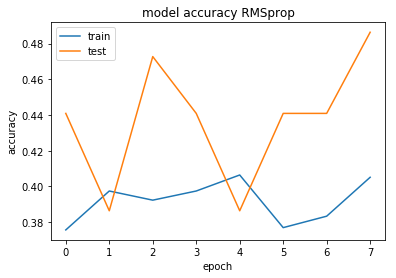

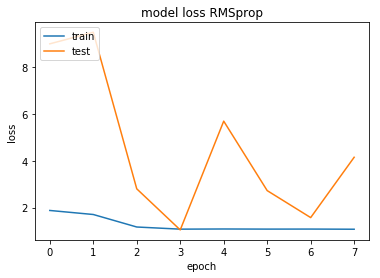

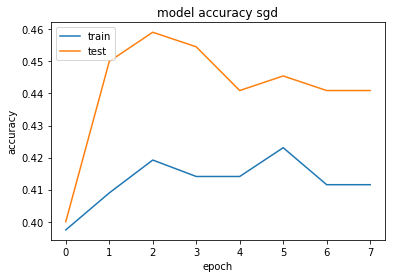

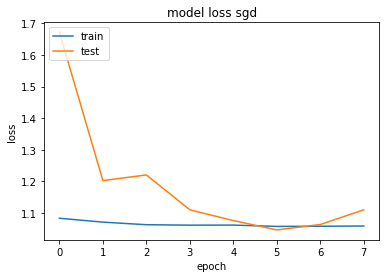

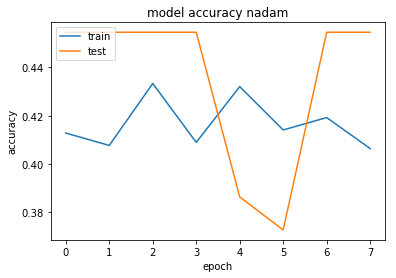

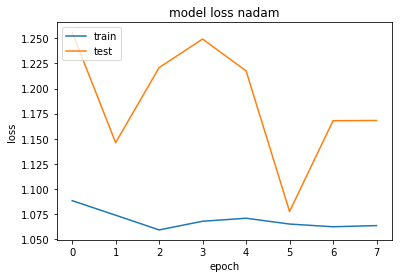

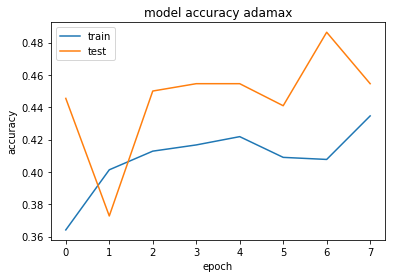

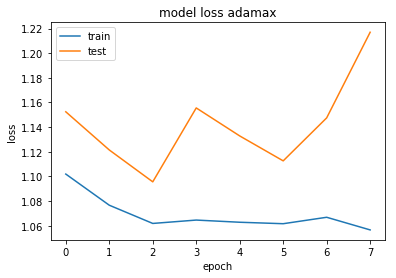

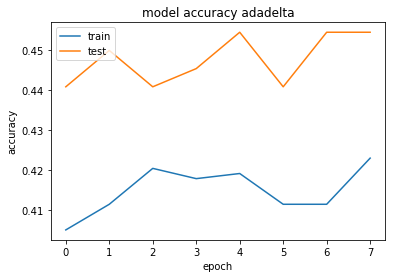

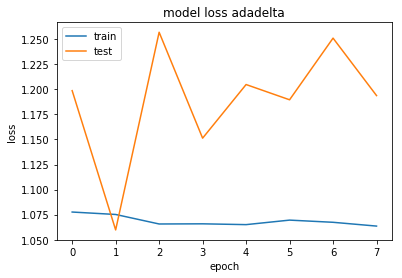

In [19]:
# list all data in history
# opts_ = ['RMSprop','sgd','nadam', 'adamax', 'adadelta']
print(historys[0].history.keys())
i = 0
for history in historys:
    # summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy ' + opts_[i])
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

# summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss ' + opts_[i])
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    i += 1


In [28]:
i = 0
for history in historys:
    print(opts_[i] + ' acc')
    print(np.mean(history.history['acc']))
    print(opts_[i] + ' loss')
    print(np.mean(history.history['loss']))
    i += 1

RMSprop acc
0.391826923301
RMSprop loss
1.26638636081
sgd acc
0.412500000153
sgd loss
1.06399479952
nadam acc
0.416826923177
nadam loss
1.06873405366
adamax acc
0.408493589906
adamax loss
1.06907953681
adadelta acc
0.415064102717
adadelta loss
1.06874341965


# Overall best: nadam

In [29]:
model = create_model('Nadam')
model = make_all_layers_non_trainable_except_last(model_current)

In [31]:
for i, layer in enumerate(model.layers):
       if layer.trainable == True: 
           print(i, layer.name)

311 global_average_pooling2d_5
312 dense_9
313 dense_10


In [34]:
train_datagen = ImageDataGenerator(rescale=1. / 255)
itr = train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=nb_train_samples,
    class_mode='categorical')

Found 6363 images belonging to 3 classes.


In [ ]:
X, y = itr.next()

In [ ]:
# zero center data
zero_centered_X = X
zero_centered_X -= np.mean(zero_centered_X, axis = 0)

In [ ]:
filepath="inception-top-weights-improvement-{epoch:02d}-{val_loss:}-{val_acc:}-{acc:}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]
tbCallBack = TensorBoard(log_dir='./graph_incep_top', histogram_freq=0, write_graph=True, write_images=True)
callbacks_list.append(tbCallBack)

In [ ]:
opt =  Nadam(lr=0.00001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, schedule_decay=0.004)
model_current.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model_current.fit(zero_centered_X, y, batch_size=16, epochs=100, validation_split=0.22, shuffle=True, initial_epoch=0)

In [ ]:
# serialize model to JSON
model_json = model.to_json()
with open("incep_top_only.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("incep_top_only.h5")
print("Saved model to disk")